In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

dataset_names = ['Roche', 'Pfizer', 'eMolecules', 'Coverage', 'Bayer']

#### Two records to skip for `Coverage`

In [2]:
name = 'Coverage'
path_to_h5 = f'../../data/qca/{name}.h5'
df = pd.read_hdf(path_to_h5)

problem_records = [df.index[98], df.index[101]]
problem_records

['c1[c@@h]2[c@@h]([c@h]2o)c[nh2+]1-0', 'c1c[nh+]c(cc1cl)[s@@](=o)[o-]-0']

In [3]:
coverage_mask = (df.index != problem_records[0]) * (df.index != problem_records[1])

In [4]:
len(df), len(df[coverage_mask])

(365, 363)

Good, expecting that to be 2 less than the original dataset

#### Extract relative energies

In [5]:
from qcelemental import constants
from simtk import unit

report_unit = unit.kilocalorie_per_mole

def to_kcal_mol(e):
    return e * constants.hartree2kcalmol

def to_relative_energies(es):
    es = [to_kcal_mol(e) for e in es]
    e_min = np.min(np.hstack(es))
    es = [e - e_min for e in es]
    return es


def get_max_relative_energies(df):
    
    # TODO: can make this step faster
    # [o.to_smiles() for o in df.offmol] # is much faster than set(df.offmol)
    # since I think set() makes calls to is_isomorphic ?
    unique_offmols = set(df.offmol)
    
    relative_energies: Dict[Molecule, List[np.ndarray]] = dict()
    for offmol in tqdm(unique_offmols):
        relative_energies[offmol] = to_relative_energies(df.energies[df.offmol == offmol])
    max_relative_energies = [np.max(np.hstack(relative_energies[offmol])) for offmol in unique_offmols]
    
    return max_relative_energies

In [6]:
# note: exception encountered unless these two records are skipped (see https://github.com/choderalab/espaloma/pull/47#issuecomment-713753019)
get_max_relative_energies(df)

Exception: Programming error: OpenEye atom stereochemistry assumptions failed.

In [7]:
max_relative_energies = get_max_relative_energies(df[coverage_mask])

100%|██████████| 52/52 [00:04<00:00, 11.81it/s]


Text(0.5, 1.0, 'Coverage')

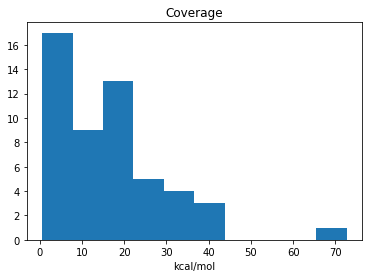

In [8]:
import matplotlib.pyplot as plt
plt.hist(max_relative_energies)
plt.xlabel('kcal/mol')
plt.title(f'{name}')

In [9]:
max_relative_energies = dict()

for name in dataset_names:
    print(name)
    path_to_h5 = f'../../data/qca/{name}.h5'
    df = pd.read_hdf(path_to_h5)
    if name == 'Coverage':
        df = df[coverage_mask]
    
    max_relative_energies[name] = get_max_relative_energies(df)

Roche


100%|██████████| 100/100 [00:02<00:00, 48.28it/s]


Pfizer


100%|██████████| 49/49 [00:01<00:00, 24.96it/s]


eMolecules


100%|██████████| 370/370 [01:10<00:00,  5.26it/s]


Coverage


100%|██████████| 52/52 [00:04<00:00, 11.10it/s]


Bayer


100%|██████████| 427/427 [01:31<00:00,  4.68it/s]


In [10]:
def plot_max_relative_energies(max_relative_energies):
    plt.hist(max_relative_energies)
    plt.xlabel(f'maximum relative energy\n({report_unit})')
    plt.ylabel('# occurrences')

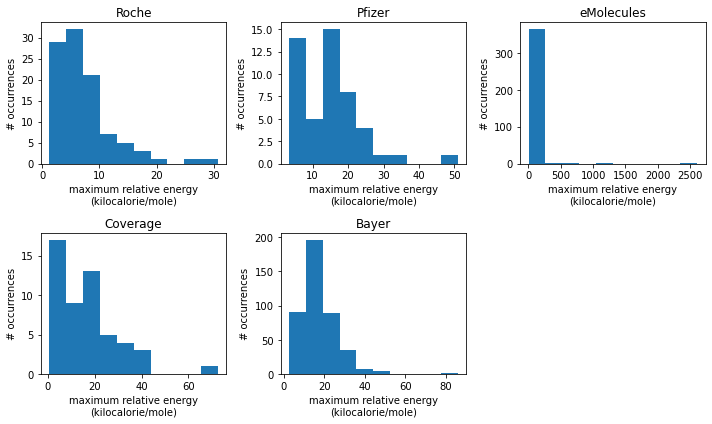

In [12]:
plt.figure(figsize=(10,6))
for i, name in enumerate(max_relative_energies):
    plt.subplot(2, 3, i+1)
    plot_max_relative_energies(max_relative_energies[name])
    plt.title(name)
plt.tight_layout()
plt.savefig('max_relative_energies.jpg', dpi=300, bbox_inches='tight')

In [13]:
# 100 kcal/mol seems on the safe side
# * Gen 2 torsion drives never exceeded ~50kcal/mol
# * and very few of these Optimization records exceeded ~100 kcal/mol
threshold = 100

In [14]:
print(f'percentage of molecules that would be removed by applying relative energy filter of {threshold} {report_unit}')
for name in max_relative_energies:
    percent_removed = 100 * np.mean(np.array(max_relative_energies[name]) > threshold)
    print(f'{name.ljust(10)}: {percent_removed:.1f}%')

percentage of molecules that would be removed by applying relative energy filter of 100 kilocalorie/mole
Roche     : 0.0%
Pfizer    : 0.0%
eMolecules: 1.9%
Coverage  : 0.0%
Bayer     : 0.0%


#### TODO: apply this filter by record, rather than by molecule